## TODO
### Need to run for longer epochs and see the results.

In [1]:
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# Custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        
        classes = list(pd.read_csv("/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv")["class"].unique())

        # Initialize the label encoder
        label_encoder = LabelEncoder()
        integer_encoded = label_encoder.fit_transform(classes)

        # Initialize the one hot encoder
        onehot_encoder = OneHotEncoder(sparse_output=False)
        integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
        onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

        # Create a dictionary to map the classes to the one hot encoding
        class_dict = {}
        for i in range(len(classes)):
            class_dict[classes[i]] = onehot_encoded[i]
            
        self.class_dict = class_dict

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_frame.iloc[idx]['path'])
        image = Image.open(img_name).convert('RGB')
        label = self.data_frame.iloc[idx]['class']
        
        if self.transform:
            image = self.transform(image)

        return image, self.class_dict[label]

# Define the transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image
])

# Initialize the dataset
TrainDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/train_data.csv', transform=data_transforms)
TestDataset = CustomImageDataset(csv_file='/Users/asmitganguly/Developer/internships/UWaterloo-24/code/data/test_data.csv', transform=data_transforms)

print(TrainDataset.__getitem__(0)[0].shape)
print(TestDataset.__getitem__(1)[0].shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


In [2]:
train_dataloader = DataLoader(TrainDataset, batch_size=4)
valid_dataloader = DataLoader(TestDataset, batch_size=4)

[1. 0. 0. 0. 0.]
torch.Size([1, 1, 224, 224])


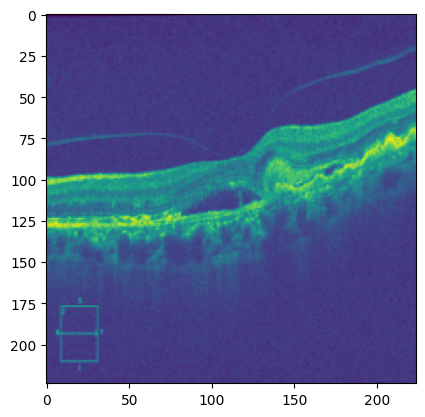

In [3]:
import matplotlib.pyplot as plt
import torch
ttp = TrainDataset.__getitem__(0)
#!convert rgb tensor to greyscale 
def rgb_to_greyscale(rgb_tensor):
    # Define the weights for the RGB channels
    weights = torch.tensor([0.299, 0.587, 0.114], device=rgb_tensor.device)
    
    # Multiply the weights with the corresponding channels and sum them up
    greyscale_tensor = (rgb_tensor * weights.view(1, 3, 1, 1)).sum(dim=1, keepdim=True)
    
    return greyscale_tensor

tt = rgb_to_greyscale(ttp[0])
p = ttp[1]
print(p)
print(tt.shape)

plt.imshow(tt[0,0])  
plt.show()

In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import sys


from torch import nn
import sys
import torch.nn.functional as F


from kan import KAN

In [15]:
device='mps'
class NormalConvsKAN(nn.Module):
    def __init__(self):
        super(NormalConvsKAN, self).__init__()
        # Convolutional layer, assuming an input with 1 channel (grayscale image)
        # and producing 16 output channels, with a kernel size of 3x3
        self.conv1 = nn.Conv2d(1, 5, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(5, 10, kernel_size=5, padding=1)
        self.conv3 = nn.Conv2d(10, 20, kernel_size=7, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()

        self.kan1 = KAN(
            width=[20,10],
            grid=10,
            k=3,
            noise_scale=0.01,
            scale_base_mu=1,
            scale_base_sigma=1,
            grid_eps=0.02,
            grid_range=[0,1])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        
        x = self.flatten(x)
        x = self.kan1(x)

        x = F.log_softmax(x, dim=1)
        return x
    
    def feature(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = self.maxpool(x)
        return x
    
    
class MIXKAN(nn.Module):
    def __init__(self):
        super(MIXKAN, self).__init__()
        self.conv4 = nn.Conv2d(20, 40, kernel_size=9, padding=1)
        self.conv5 = nn.Conv2d(40, 50, kernel_size=11, padding=1)

        # Max pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        """self, width=None, grid=3, k=3, noise_scale=0.1, scale_base_mu=0.0, scale_base_sigma=1.0, base_fun=torch.nn.SiLU(), symbolic_enabled=True, bias_trainable=False, grid_eps=1.0, grid_range=[-1, 1], sp_trainable=True, sb_trainable=True, device='cpu', seed=0"""

        self.kan1 = KAN(
            width=[50,5],
            grid=10,
            k=3,
            noise_scale=0.01,
            scale_base_mu=1,
            scale_base_sigma=1,
            grid_eps=0.02,
            grid_range=[0,1])
        

    def forward(self, x):
        x = F.relu(self.conv4(x))
        x = self.maxpool(x)
        x = F.relu(self.conv5(x))
        
        x = self.flatten(x)
        x = self.kan1(x)

        x = F.log_softmax(x, dim=1)
        return x




model_feature = NormalConvsKAN()
model_feature.load_state_dict(torch.load("./weights/Convs_and_KAN_pykan.pth"))
model_feature.to(device)
model_class = MIXKAN().to(device)

out = model_class(model_feature.feature(tt.to(device)))
print("out: ", out.shape)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


/var/folders/1x/ys4528cx32123ww1dck2swg40000gn/T/ipykernel_29329/34406912.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_feature.load_state_dict(torch.load("./w

out:  torch.Size([1, 5])


In [16]:
print(out)

tensor([[-1.7160, -1.6404, -1.5812, -1.6813, -1.4505]], device='mps:0',
       grad_fn=<LogSoftmaxBackward0>)


In [17]:
print(torch.argmax(out, dim=1))

tensor([4], device='mps:0')
